In [1]:
!pip install d2l==1.0.3


In [2]:
import torch
from torch import nn
import torch.nn.functional as F  # Add this import
from d2l import torch as d2l

In [3]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [4]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  8., 10., 12.,  0.],
        [ 0.,  0., 20., 22., 24.,  0.,  0., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [5]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

        self.variances_1 = []  # List to store variances for layer 1
        self.variances_2 = []  # List to store variances for layer 2

        # Register hooks to capture activations
        self.hook_1 = self.lin1.register_forward_hook(self.capture_activations(1))
        self.hook_2 = self.lin2.register_forward_hook(self.capture_activations(2))

    def capture_activations(self, layer_num):
        def hook(module, input, output):
            activations = F.relu(output)  # Apply ReLU to activations
            variance = torch.var(activations, dim=1).mean().item()
            
            if layer_num == 1:
                self.variances_1.append(variance)
            elif layer_num == 2:
                self.variances_2.append(variance)

        return hook

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

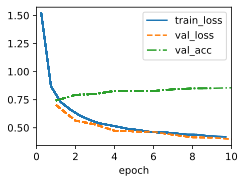

In [6]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

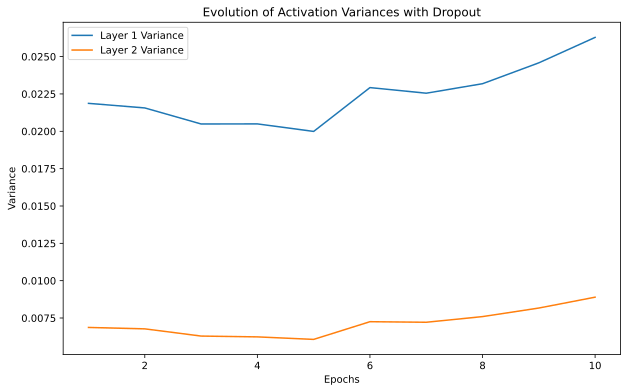

In [7]:
import matplotlib.pyplot as plt

# Plot the variances over epochs
epochs = list(range(1, trainer.max_epochs + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, model.variances_1[:10], label='Layer 1 Variance')
plt.plot(epochs, model.variances_2[:10], label='Layer 2 Variance')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.title('Evolution of Activation Variances with Dropout')
plt.legend()
plt.show()